# Brain Tumor Detection using CNN and tranfer learning

_We will create a model which will correctly classify if the MRI image of the brain has tumor or not._

# Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K

import cv2
import shutil
import glob
import os

# Data import & preprocessing

In [2]:
data = 'brain-mri-images-for-brain-tumor-detection/'
No_brain_tumor = 'brain-mri-images-for-brain-tumor-detection/no/'
Yes_brain_tumor = 'brain-mri-images-for-brain-tumor-detection/yes/'

In [3]:
dirlist=[No_brain_tumor, Yes_brain_tumor]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  253    labels:  253


In [4]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(253,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,brain-mri-images-for-brain-tumor-detection/no/...,No
1,brain-mri-images-for-brain-tumor-detection/no/...,No
2,brain-mri-images-for-brain-tumor-detection/no/...,No
3,brain-mri-images-for-brain-tumor-detection/no/...,No
4,brain-mri-images-for-brain-tumor-detection/no/...,No


In [5]:
print(df['labels'].value_counts())

Yes    155
No      98
Name: labels, dtype: int64


# visualize brain tumor images

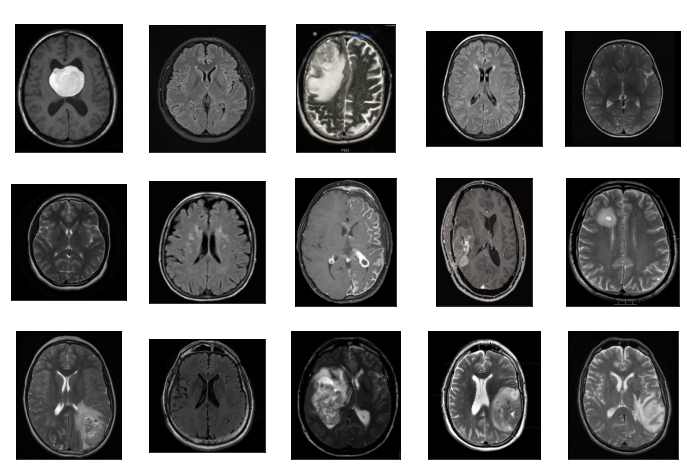

In [6]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (216, 2)
test set shape: (13, 2)
validation set shape: (24, 2)


Let's start the modelling task
The ImageDataGenerator for keras is awesome.
It lets you augment your images in real-time while your model is still training! 
You can apply any random transformations on each training image as it is passed to the model. 
This will not only make your model robust but will also save up on the overhead memory!


We will apply the Image Data Generator on training with various parameters, but we won't apply 
the same parameters on testin. Why?
Because we want the test iamges as it is, we don't want biasedness,
also if we fit it we will be applying
the model only on these test images only, it can't predict new images if fed into model
Because new images will not be augmented this way

# Data Augmentation

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

Now fit the them to get the images from directory (name of the images are given in dataframe) with augmentation

In [9]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (150,150), batch_size = 16, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(150,150), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (150,150), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 216 validated image filenames belonging to 2 classes.
Found 24 validated image filenames belonging to 2 classes.
Found 13 validated image filenames belonging to 2 classes.


In [10]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

# CNN model

In [11]:
base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', input_shape = (200,200,3),
                                                     include_top=False)
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
batch_normalization_203 (Bat (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 54,534,113
Trainable params: 54,473,313
Non-trainable params: 60,800
_______________________________________

In [12]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
]


model.compile(loss='binary_crossentropy', optimizer=Adam(lr = 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 40, 
                    callbacks = [callbacks], verbose = 1)

/Users/sebastian/.conda/envs/pythonProject2/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/40
14/14 [==============================] - 108s 6s/step - loss: 0.7308 - accuracy: 0.5926 - val_loss: 0.6781 - val_accuracy: 0.5833
Epoch 2/40
14/14 [==============================] - 80s 6s/step - loss: 0.5050 - accuracy: 0.7731 - val_loss: 0.5669 - val_accuracy: 0.6667
Epoch 3/40
14/14 [==============================] - 80s 6s/step - loss: 0.4419 - accuracy: 0.7824 - val_loss: 0.6106 - val_accuracy: 0.7917
Epoch 4/40
14/14 [==============================] - 89s 6s/step - loss: 0.3595 - accuracy: 0.8426 - val_loss: 0.5933 - val_accuracy: 0.6667
Epoch 5/40
14/14 [==============================] - 89s 6s/step - loss: 0.3766 - accuracy: 0.8380 - val_loss: 0.5162 - val_accuracy: 0.7917
Epoch 6/40
14/14 [==============================] - 84s 6s/step - loss: 0.3010 - accuracy: 0.8704 - val_loss: 0.3716 - val_accuracy: 0.8750
Epoch 7/40
14/14 [==============================] - 85s 6s/step - loss: 0.2683 - accuracy: 0.8935 - val_loss: 0.3811 - val_accuracy: 0.8333
Epoch 8/40
14/14 [=

In [15]:
model.load_weights("Tumor_classifier_model.h5")
model.evaluate(test_gen)

1/1 [==============================] - 1s 1s/step - loss: 0.2917 - accuracy: 0.8462


[0.29174694418907166, 0.8461538553237915]

**84.6% Accuracy on test set**

# plot model performance

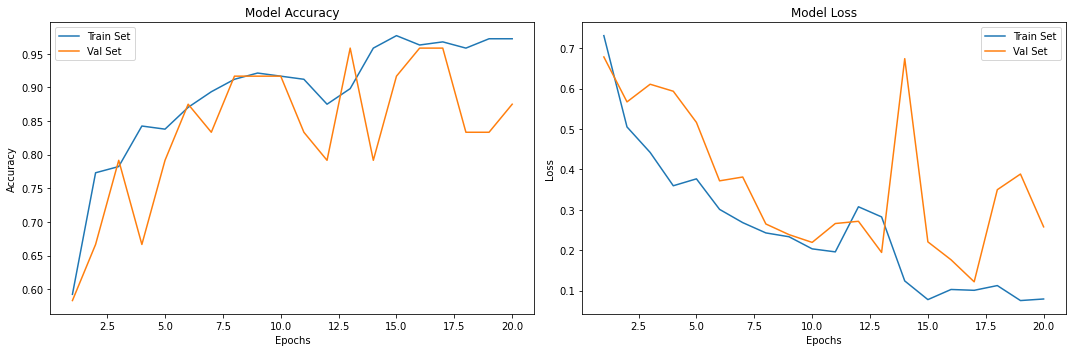

In [16]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()